# ECB Interest Rate Predictions with LSTM


from Stock Market prediction
Datacamp Tutorial: https://www.datacamp.com/community/tutorials/lstm-python-stock-market


In [1]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [343]:
frames = {}

# Data from European Central Bank - Statistical Data Warehouse

groups = {
    'InflationRate':'1_inflation_rate', 
    'M3':'2_money_supply_M3', 
    'GDP':'3_GDP', 
    'labourCosts':'4_labour_costs', 
    'population':'5_population', 
    'unemploymentRate':'6_unemployment_rate', 
#     'labourProductivity':'7_labour_productivity', 
    'currentAccountBalance':'8_current_account_balance', 
    'USEURexchangeRate':'9_US_EUR_echange_rate', 
    'GovernmentDeficit':'10_government_deficit_surplus',
    'govermentDebt':'11_goverment_debt', 
#     'depositFacilityLevel':'ECB_deposit_Lending',
    'marginalLendingFacilityLevel':'ECB_deposit_Lending'
    
    #    'depositFacilityChange':'ECB_Deposit_facility_change', 
    #    'depositFacilityLevel':'ECB_Deposit_facility_level', 
    #    'marginalLendingFacilityChange':'ECB_Marginal_lending_facility_change', 
    #     'marginalLendingFacilityLevel':'ECB_Marginal_lending_facility_level'
}

data_date_ranges = []

ealiest_start_date = dt.datetime.now()
latest_start_date = dt.datetime(11,1,1)
ealiest_end_date = dt.datetime.now()
latest_end_date = dt.datetime(11,1,1)

print("Date Ranges for Data Elements from ECB")
print("======================================\n")

for grp in groups:
    #do some calcs to get a dataframe called 'df'
    filedata = pd.read_csv("../../../"+groups[grp]+".csv",delimiter=',',
                                                                   usecols=['date',grp])
    filedata['date'] = pd.to_datetime(filedata['date'], format='%d/%m/%Y')
    filedata.set_index('date', inplace=True)
    # sort indexs by date 
    df_merged = filedata.sort_values('date', inplace=True)
    
    data_date_ranges.append([grp,filedata.index[0],filedata.index[-1]])
    
    print("-",filedata.iloc[[0,-1]], "\n Records: ", filedata.shape[0])
    frames[grp] = filedata
    if filedata.index[0]<ealiest_start_date:
        ealiest_start_date = filedata.index[0]
    if filedata.index[0]>latest_start_date:
        latest_start_date = filedata.index[0]
    if filedata.index[-1]<ealiest_end_date:
        ealiest_end_date = filedata.index[-1]
    if filedata.index[-1]>latest_end_date:
        latest_end_date = filedata.index[-1]



Date Ranges for Data Elements from ECB

-             InflationRate
date                     
1999-01-31            0.8
2021-02-28            1.3 
 Records:  267
-                M3
date             
1999-01-31   6.13
2021-01-31  12.48 
 Records:  265
-              GDP
date            
1999-03-31  2.15
2020-12-31 -4.92 
 Records:  88
-             labourCosts
date                   
1999-03-31         1.66
2020-12-31         3.91 
 Records:  88
-             population
date                  
1999-12-31      319.37
2021-04-07      342.41 
 Records:  23
-             unemploymentRate
date                        
1999-01-31             10.07
2021-01-31              8.10 
 Records:  265
-             currentAccountBalance
date                             
1999-03-31                  -0.57
2020-12-31                   3.75 
 Records:  88
-             USEURexchangeRate
date                         
1999-01-04               1.18
2021-03-22               1.19 
 Records:  5750
-             G

In [344]:
df = pd.DataFrame(data_date_ranges, columns = ['Data','Start', 'End'])
df.set_index('Data', inplace=True)

df.to_csv("data_date_ranges.csv")

In [345]:
df

,Start,End
Data,,
InflationRate,1999-01-31,2021-02-28
M3,1999-01-31,2021-01-31
GDP,1999-03-31,2020-12-31
labourCosts,1999-03-31,2020-12-31
population,1999-12-31,2021-04-07
unemploymentRate,1999-01-31,2021-01-31
currentAccountBalance,1999-03-31,2020-12-31
USEURexchangeRate,1999-01-04,2021-03-22
GovernmentDeficit,1999-03-31,2020-09-30


<h1>Datasets</h1>
<h2>Different Date ranges for datasets</h2>
<ul>
    <li>As we have different start dates and end dates for each datatype.</li>
    <li>The merged data will have blanks at the start and end for some colums</li>
    <li><b>Solution:</b> We can time interpolate for the blanks at the end and backfill for the blanks for the start</li>
    <li>We can also reduce the dataset to only the time period where all data has records</li>
    <li>the latest start date and the earliest end date of all datasets</li>
</ul>
       

In [346]:
# What date range do we have full information
print("\nStarting dates: ", ealiest_start_date, " - ", latest_start_date)
print("Ending Dates:   ", ealiest_end_date, " - ", latest_end_date)

print("\nRange wth full data: ", latest_start_date, " - ", ealiest_end_date)


Starting dates:  1999-01-01 00:00:00  -  1999-12-31 00:00:00
Ending Dates:    2020-09-30 00:00:00  -  2021-04-07 00:00:00

Range wth full data:  1999-12-31 00:00:00  -  2020-09-30 00:00:00


 
<h2>Different reporting periods</h2>
<ul>
    <li>As we have different reporting periods monthly and daily</li>
    <li>The merged data will have blanks for some columns where there are not values for that day</li>
    <li><b>Solution:</b> We can time interpolate the data to fill in the blanks</li>
    <li>We want to fill in these blanks so the model can learn from each date entry with valid data for each roe</li>
</ul>

<h2>Missing Dates from full data</h2>
<ul>
    <li>As we have different reporting dates, such as no weekend data</li>
    <li>The merged data will have no entries for these date</li>
    <li><b>Solution:</b> We can add the dates to the data but they will have all blank fields</li>
    <li> We can time interpolate for the blanks </li>
    <li>we want to fill in all dates so the model will have continuous data to learn from and not be affected by gaps</li>
</ul>

In [347]:
# merge the datasets into one matrix 
# as the different  datasets have different 
# we will have some blanks for some columns at the start and the end

from functools import reduce

data_frames = list(frames.values())
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date'], how='outer'), data_frames)

In [348]:
# sort indexs by date 
df_merged = df_merged.sort_values('date')

In [349]:
print("start df merged:",df_merged.iloc[0], df_merged.iloc[-1] )

start df merged: InflationRate                   NaN
M3                              NaN
GDP                             NaN
labourCosts                     NaN
population                      NaN
unemploymentRate                NaN
currentAccountBalance           NaN
USEURexchangeRate               NaN
GovernmentDeficit               NaN
govermentDebt                   NaN
marginalLendingFacilityLevel    4.5
Name: 1999-01-01 00:00:00, dtype: float64 InflationRate                      NaN
M3                                 NaN
GDP                                NaN
labourCosts                        NaN
population                      342.41
unemploymentRate                   NaN
currentAccountBalance              NaN
USEURexchangeRate                  NaN
GovernmentDeficit                  NaN
govermentDebt                      NaN
marginalLendingFacilityLevel      0.25
Name: 2021-04-07 00:00:00, dtype: float64


In [350]:
df_merged.head(3)

,InflationRate,M3,GDP,labourCosts,population,unemploymentRate,currentAccountBalance,USEURexchangeRate,GovernmentDeficit,govermentDebt,marginalLendingFacilityLevel
date,,,,,,,,,,,
1999-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5
1999-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5
1999-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5


In [351]:
# Interpolate missing vaariables (as some datapints are monthly and some quarterly and some daily)
for key, value in df_merged.iteritems():
    nans = df_merged[key].isna().sum()
    print(key + " NaNs: " + str(nans))
    if nans > 0:
        df_merged[key] = df_merged[key].interpolate(method='time')
        nans2 = df_merged[key].isna().sum()
#         print("After interpolate time: " + str(nans2))
        if nans2 > 0:
#             print(df_merged.iloc[0:nans2+1][key])
            df_merged[key] = df_merged[key].interpolate(method="backfill")
            nans3 = df_merged[key].isna().sum()
#             print("After backfill: " + str(nans3))        
#             print(df_merged.iloc[0:nans2+1][key])
    after = df_merged[key].isna().sum()
    print(key + " NaNs: " + str(after))


InflationRate NaNs: 7867
InflationRate NaNs: 0
M3 NaNs: 7869
M3 NaNs: 0
GDP NaNs: 8046
GDP NaNs: 0
labourCosts NaNs: 8046
labourCosts NaNs: 0
population NaNs: 8111
population NaNs: 0
unemploymentRate NaNs: 7869
unemploymentRate NaNs: 0
currentAccountBalance NaNs: 8046
currentAccountBalance NaNs: 0
USEURexchangeRate NaNs: 2446
USEURexchangeRate NaNs: 0
GovernmentDeficit NaNs: 8062
GovernmentDeficit NaNs: 0
govermentDebt NaNs: 8051
govermentDebt NaNs: 0
marginalLendingFacilityLevel NaNs: 0
marginalLendingFacilityLevel NaNs: 0


<h1>Truncate data time period to where we have full data for all fields</h1>
For example we have some columns which do not span the full period and we want to reduce to the lowest date range where all data is represented

In [352]:
# truncate dataset range where we have all variables
df_fulldata = df_merged[latest_start_date : ealiest_end_date]

In [353]:
print("Date range of all data: ", df_merged.index[0], "to", df_merged.index[-1])
print("Date range of trimmed data: ", df_fulldata.index[0], "to", df_fulldata.index[-1])

Date range of all data:  1999-01-01 00:00:00 to 2021-04-07 00:00:00
Date range of trimmed data:  1999-12-31 00:00:00 to 2020-09-30 00:00:00


In [437]:
flds = df_fulldata.columns
cols = len(flds)

In [438]:
flds

Index(['InflationRate', 'M3', 'GDP', 'labourCosts', 'population',
       'unemploymentRate', 'currentAccountBalance', 'USEURexchangeRate',
       'GovernmentDeficit', 'govermentDebt', 'marginalLendingFacilityLevel'],
      dtype='object')

<h1>Correlation Matrix for Datapoint from ECB</h1>

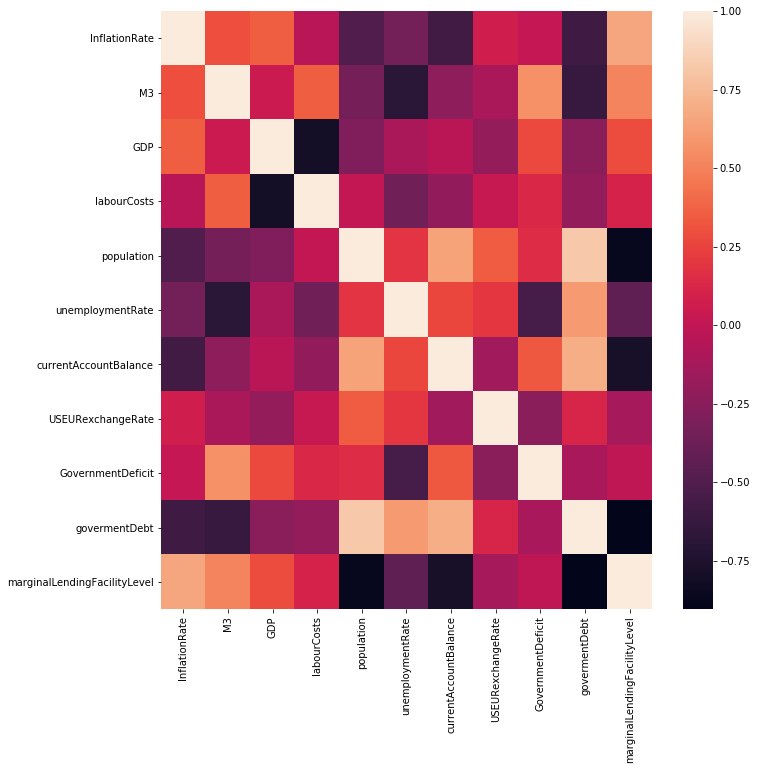

In [439]:
import seaborn as sns
%matplotlib inline

# calculate the correlation matrix
corr = df_fulldata.corr()
plt.figure(figsize = (11,11))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

plt.show()

<h1>Print Data Elements that have a high correlation</h1>
These are columns which have a direct correlation to each other and may indicate if we have redundant data elements

In [442]:
print("Strongly correlated datapoints\n==================================")

for i in range(cols):
    for j in range(i+1, cols):
        if corr.iloc[i][j] > 0.80:
            print (flds[i], ' \t\t\t', flds[j], ' \t\t', corr.iloc[i][j])
            
          

Strongly correlated datapoints
population  			 govermentDebt  		 0.8263918442764493


We can see that there is a <b>strong direct correlation</b> between:

<h2>GDP and Labour Productivity </h2>

We could therefore identify which of these 2 data points we can more accurately predict and measure and provide this to the model

<h2>depositFacilityLevel and    marginalLendingFacilityLevel</h2>

We see the direct correlation between our target variable <b>lending interest rate</b> and the <b>deposit level interest rate</b>

In [447]:
print("Strongly inversely correlated datapoints\n==================================")
for i in range(cols):
    for j in range(i+1, cols):
        if corr.iloc[i][j] < -0.60:
            print (flds[i], ' \t\t', flds[j], ' \t', corr.iloc[i][j])

Strongly inversely correlated datapoints
M3  		 unemploymentRate  	 -0.6942183703027538
M3  		 govermentDebt  	 -0.6218025548559165
GDP  		 labourCosts  	 -0.8016891088679259
population  		 marginalLendingFacilityLevel  	 -0.8702819493420634
currentAccountBalance  		 marginalLendingFacilityLevel  	 -0.7842459552336879
govermentDebt  		 marginalLendingFacilityLevel  	 -0.9039584129305372


We can see a <b>very strong inverse correlation</b> between:

<h2>labour Costs and labour Productivity</h2>
Perhaps one of these can be ignored as a redundant variable

<h2>population and marginal lending rate</h2>

<h2>Government Debt and depositFacilityLevel</h2>

<h2>Government Debt and interest rates- marginalLendingFacilityLevel</h2>

Therefore if we can predict our population growth or predict accurately our government debt we can predict an inverse decrease in interest rates

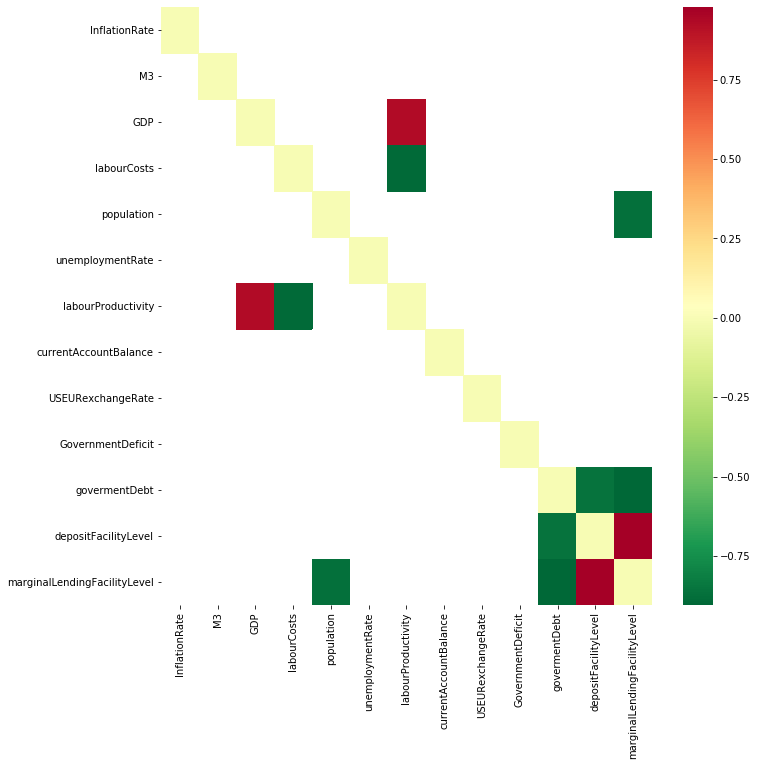

In [333]:
kot = corr[np.abs(corr)>=.85]

#hiding self correlation
np.fill_diagonal(kot.values, 0)
plt.figure(figsize = (11,11))

# plot the heatmap
sns.heatmap(kot, cmap='RdYlGn_r',
        xticklabels=corr.columns,
        yticklabels=corr.columns)

plt.show()

In [356]:
print(df_fulldata.index[0], "to", df_fulldata.index[-1])

1999-12-31 00:00:00 to 2020-09-30 00:00:00


### Data Exploration

Here you will print the data you collected in to the dataframe. You also will make sure that the data is sorted by the date. Because the order of data is crucial in time series modelling. 

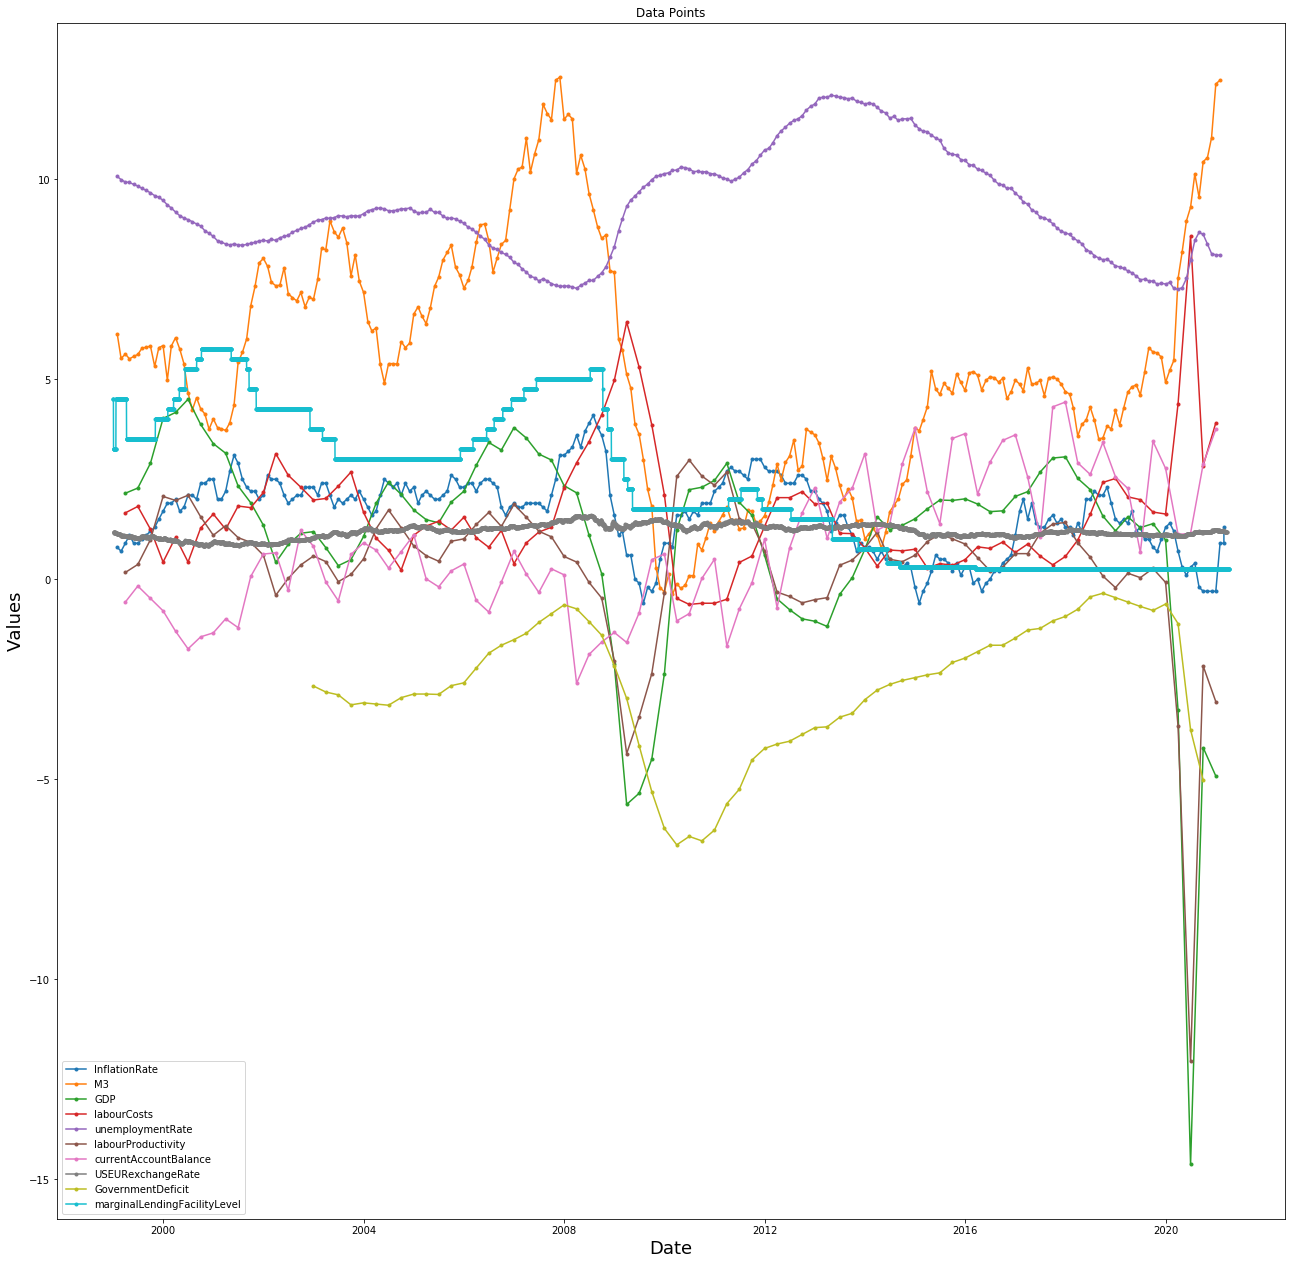

In [273]:
plt.figure(figsize = (22,22))
# plt.plot(df_merged['M3'],'.-')
for key, value in df_fulldata.iteritems():
    if (value[5] < 50):
        plt.plot(frames[key],'.-', label=key)
# plt.xticks(range(0,df.shape[0],20),df['date'].loc[::20],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Values',fontsize=18)
plt.legend()
plt.title("Data Points")
plt.show()

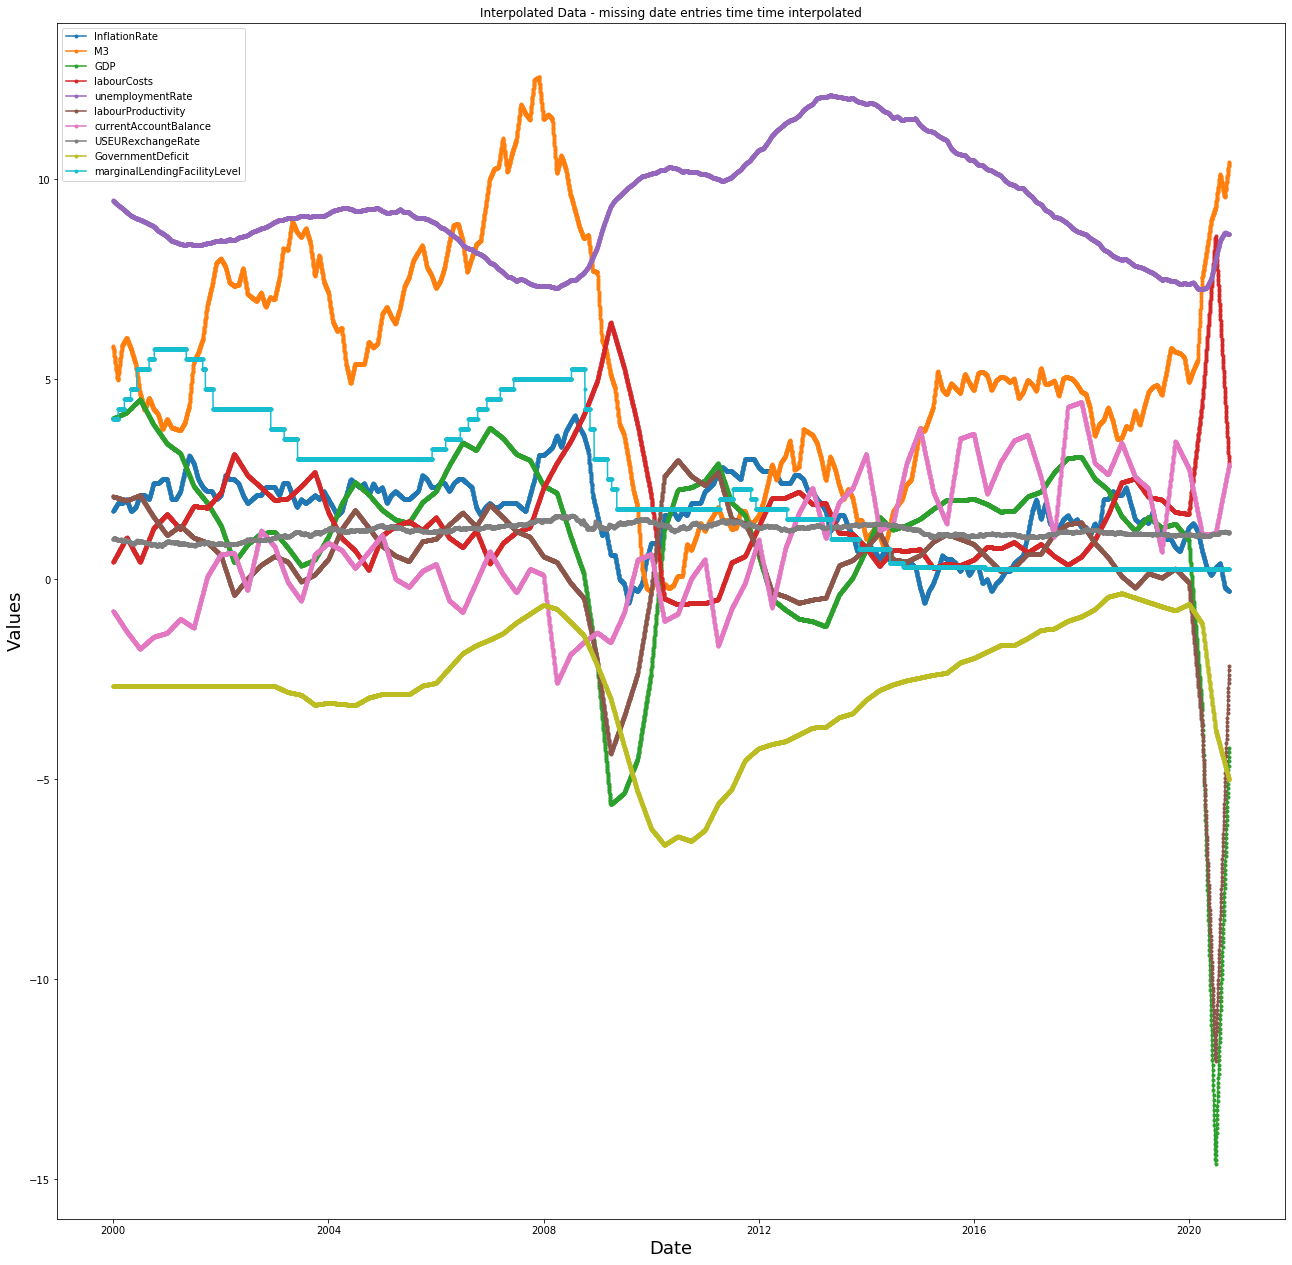

In [276]:
plt.figure(figsize = (22,22))
# plt.plot(df_merged['M3'],'.-')
for key, value in df_fulldata.iteritems():
    if (value[5] < 50):
        plt.plot(df_fulldata[key],'.-', label=key)
# plt.xticks(range(0,df.shape[0],20),df['date'].loc[::20],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Values',fontsize=18)
plt.legend()
plt.title("Interpolated Data - missing date entries time time interpolated")
plt.show()

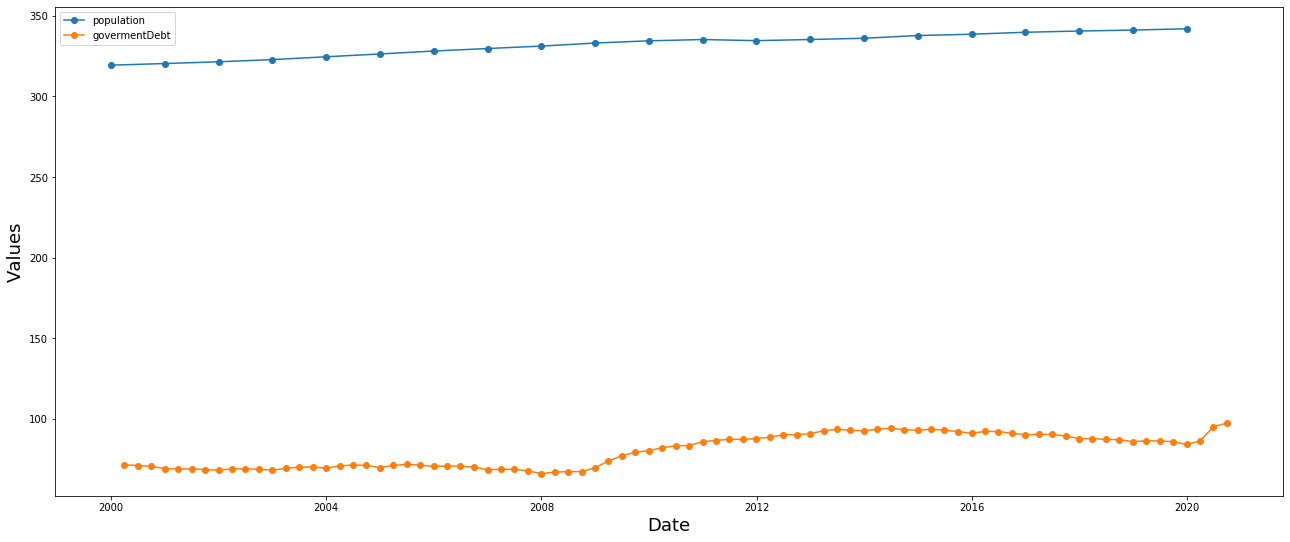

In [135]:
plt.figure(figsize = (22,9))
# plt.plot(df_fulldata['M3'],'o-')
for key, value in df_fulldata.iteritems():
    if (value[5] > 49):
        plt.plot(frames[key],'o-', label=key)
# plt.xticks(range(0,df.shape[0],20),df['date'].loc[::20],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Values',fontsize=18)
plt.legend()
plt.show()

<h1>Scale Data to be between 0 - 1

Now you need to define a scaler to normalize data `MinMaxScalar` scales all the data to be in the region of 0 and 1. You also reshape the train and test data to be in the shape `[data_size, num_features]`.

In [277]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data w.r.t training data
# Because you are not supposed to have access to test data

scaler = MinMaxScaler()

data = pd.DataFrame(scaler.fit_transform(df_fulldata.values), columns=df_fulldata.columns, index=df_fulldata.index)

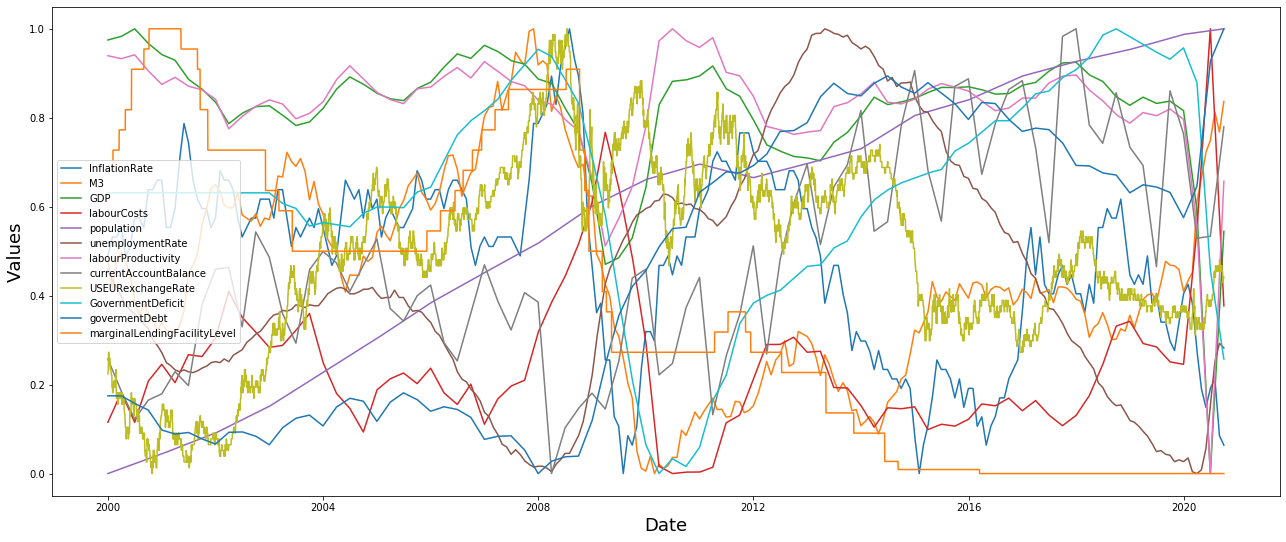

In [278]:
plt.figure(figsize = (22,9))
selected = data.columns
# selected = ['InflationRate', 'marginalLendingFacilityLevel']
for key in selected:
    plt.plot(data[key],'-', label=key)
# for key, value in df_merged.iteritems():
#     plt.plot(data[key],'-', label=key)
# plt.xticks(range(0,df.shape[0],20),data['date'].loc[::20],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Values',fontsize=18)
plt.legend()
plt.show()

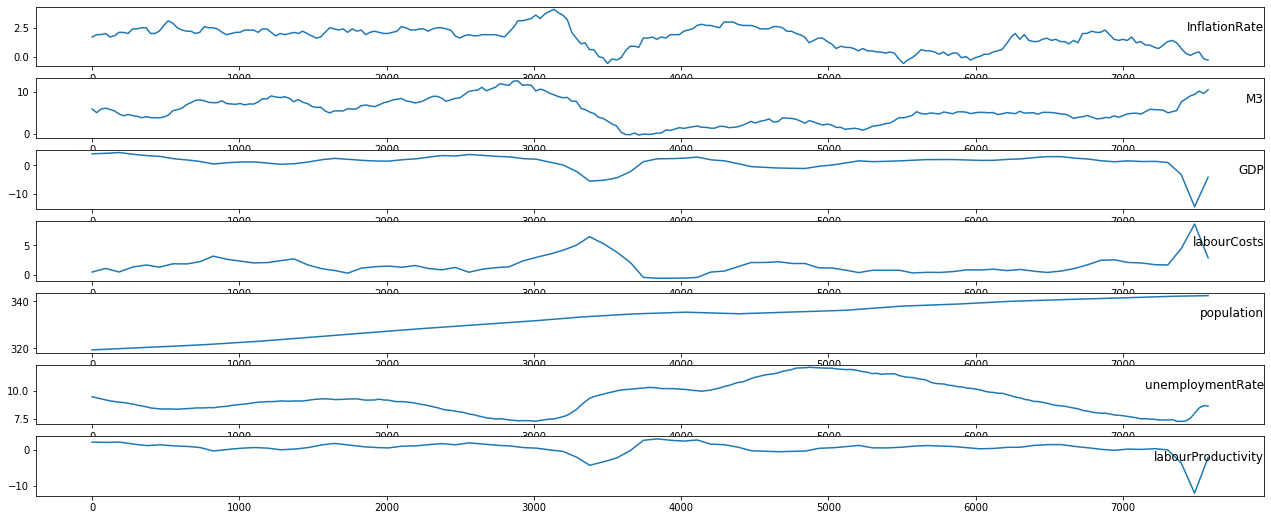

In [279]:
from matplotlib import pyplot
# load dataset
values = df_fulldata.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure(figsize = (22,9))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df_fulldata.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [364]:
cols = list(df_fulldata.columns)
print(cols)
cols = [cols[-1]] + cols[:-1]
print(cols)
df_fulldata2 = df_fulldata[cols]
df_fulldata2.to_csv("ecb.csv")

['InflationRate', 'M3', 'GDP', 'labourCosts', 'population', 'unemploymentRate', 'currentAccountBalance', 'USEURexchangeRate', 'GovernmentDeficit', 'govermentDebt', 'marginalLendingFacilityLevel']
['marginalLendingFacilityLevel', 'InflationRate', 'M3', 'GDP', 'labourCosts', 'population', 'unemploymentRate', 'currentAccountBalance', 'USEURexchangeRate', 'GovernmentDeficit', 'govermentDebt']


In [281]:
df_fulldata2.head(0)

,marginalLendingFacilityLevel,InflationRate,M3,GDP,labourCosts,population,unemploymentRate,labourProductivity,currentAccountBalance,USEURexchangeRate,GovernmentDeficit,govermentDebt
date,,,,,,,,,,,,


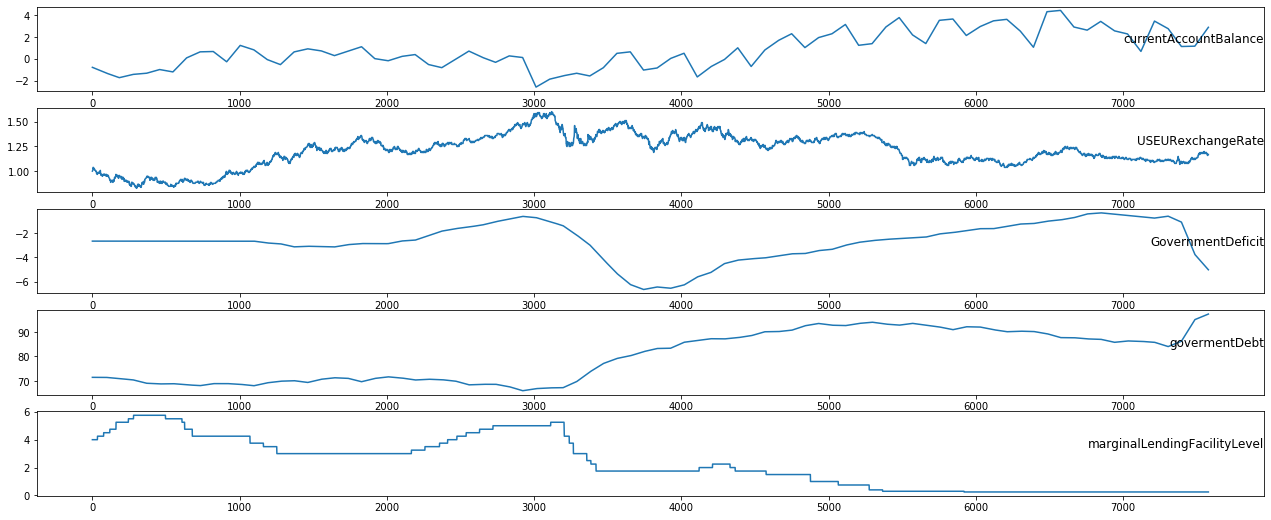

In [282]:
groups = [7, 8, 9, 10, 11]
i = 1
# plot each column
plt.figure(figsize = (22,9))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df_fulldata.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [300]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('ecb.csv', header=0, index_col=0)
print(dataset.head(5))

values = dataset.values
# # integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 30, 1)
# drop columns we don't want to predict
print(reframed.shape)
reframed = reframed.iloc[: , :-11]
# reframed.drop(reframed.columns[[13, 14, 15,  16, 17, 18, 19, 20, 21, 22, 23]], axis=1, inplace=True)
reframed.to_csv("reframed.csv")
print(reframed.head(1))



            marginalLendingFacilityLevel  InflationRate        M3       GDP  \
date                                                                          
1999-12-31                           4.0       1.700000  5.840000  4.020000   
2000-01-01                           4.0       1.706452  5.812258  4.021648   
2000-01-02                           4.0       1.712903  5.784516  4.023297   
2000-01-03                           4.0       1.719355  5.756774  4.024945   
2000-01-04                           4.0       1.725806  5.729032  4.026593   

            labourCosts  population  unemploymentRate  labourProductivity  \
date                                                                        
1999-12-31     0.430000  319.370000          9.470000            2.070000   
2000-01-01     0.436813  319.372760          9.466452            2.068901   
2000-01-02     0.443626  319.375519          9.462903            2.067802   
2000-01-03     0.450440  319.378279          9.459355        

In [284]:
# split into train and test sets
values = reframed.values
n_train_days = 365 * 18
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6570, 1, 12) (6570,) (1009, 1, 12) (1009,)


In [285]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)


Train on 6570 samples, validate on 1009 samples
Epoch 1/1000
6570/6570 [==============================] - ETA: 0s - loss: 0.354 - 2s 255us/step - loss: 0.3132 - val_loss: 0.0149
Epoch 2/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.2297 - val_loss: 0.0312
Epoch 3/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.1197 - val_loss: 0.0768
Epoch 4/1000
6570/6570 [==============================] - 0s 29us/step - loss: 0.0957 - val_loss: 0.0530
Epoch 5/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.0715 - val_loss: 0.0743
Epoch 6/1000
6570/6570 [==============================] - 0s 38us/step - loss: 0.0531 - val_loss: 0.0546
Epoch 7/1000
6570/6570 [==============================] - 0s 38us/step - loss: 0.0581 - val_loss: 0.0728
Epoch 8/1000
6570/6570 [==============================] - 0s 31us/step - loss: 0.0648 - val_loss: 0.0732
Epoch 9/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.0722 -

6570/6570 [==============================] - 0s 31us/step - loss: 0.0176 - val_loss: 0.0217
Epoch 78/1000
6570/6570 [==============================] - 0s 30us/step - loss: 0.0262 - val_loss: 0.0215
Epoch 79/1000
6570/6570 [==============================] - 0s 30us/step - loss: 0.0251 - val_loss: 0.0269
Epoch 80/1000
6570/6570 [==============================] - 0s 30us/step - loss: 0.0207 - val_loss: 0.0213
Epoch 81/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.0118 - val_loss: 0.0239
Epoch 82/1000
6570/6570 [==============================] - 0s 32us/step - loss: 0.0112 - val_loss: 0.0202
Epoch 83/1000
6570/6570 [==============================] - 0s 38us/step - loss: 0.0111 - val_loss: 0.0216
Epoch 84/1000
6570/6570 [==============================] - 0s 37us/step - loss: 0.0124 - val_loss: 0.0276
Epoch 85/1000
6570/6570 [==============================] - 0s 30us/step - loss: 0.0194 - val_loss: 0.0217
Epoch 86/1000
6570/6570 [==============================] - 0

Epoch 154/1000
6570/6570 [==============================] - 0s 29us/step - loss: 0.0147 - val_loss: 0.0285
Epoch 155/1000
6570/6570 [==============================] - 0s 30us/step - loss: 0.0126 - val_loss: 0.0265
Epoch 156/1000
6570/6570 [==============================] - 0s 30us/step - loss: 0.0149 - val_loss: 0.0232
Epoch 157/1000
6570/6570 [==============================] - 0s 31us/step - loss: 0.0146 - val_loss: 0.0229
Epoch 158/1000
6570/6570 [==============================] - 0s 32us/step - loss: 0.0130 - val_loss: 0.0212
Epoch 159/1000
6570/6570 [==============================] - 0s 39us/step - loss: 0.0130 - val_loss: 0.0194
Epoch 160/1000
6570/6570 [==============================] - 0s 36us/step - loss: 0.0112 - val_loss: 0.0188
Epoch 161/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.0090 - val_loss: 0.0196
Epoch 162/1000
6570/6570 [==============================] - 0s 30us/step - loss: 0.0082 - val_loss: 0.0215
Epoch 163/1000
6570/6570 [===========

6570/6570 [==============================] - 0s 27us/step - loss: 0.0122 - val_loss: 0.0236
Epoch 231/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.0120 - val_loss: 0.0255
Epoch 232/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.0247 - val_loss: 0.0377
Epoch 233/1000
6570/6570 [==============================] - 0s 26us/step - loss: 0.0098 - val_loss: 0.0289
Epoch 234/1000
6570/6570 [==============================] - 0s 26us/step - loss: 0.0151 - val_loss: 0.0287
Epoch 235/1000
6570/6570 [==============================] - 0s 32us/step - loss: 0.0147 - val_loss: 0.0299
Epoch 236/1000
6570/6570 [==============================] - 0s 25us/step - loss: 0.0125 - val_loss: 0.0226
Epoch 237/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.0221 - val_loss: 0.0139
Epoch 238/1000
6570/6570 [==============================] - 0s 30us/step - loss: 0.0244 - val_loss: 0.0133
Epoch 239/1000
6570/6570 [==========================

6570/6570 [==============================] - 0s 27us/step - loss: 0.0099 - val_loss: 0.0235
Epoch 307/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.0083 - val_loss: 0.0240
Epoch 308/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.0069 - val_loss: 0.0264
Epoch 309/1000
6570/6570 [==============================] - 0s 26us/step - loss: 0.0085 - val_loss: 0.0192
Epoch 310/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.0076 - val_loss: 0.0230
Epoch 311/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.0107 - val_loss: 0.0165
Epoch 312/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.0078 - val_loss: 0.0248
Epoch 313/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.0142 - val_loss: 0.0194
Epoch 314/1000
6570/6570 [==============================] - 0s 26us/step - loss: 0.0098 - val_loss: 0.0194
Epoch 315/1000
6570/6570 [==========================

6570/6570 [==============================] - 0s 36us/step - loss: 0.0156 - val_loss: 0.0162
Epoch 383/1000
6570/6570 [==============================] - 0s 30us/step - loss: 0.0134 - val_loss: 0.0166
Epoch 384/1000
6570/6570 [==============================] - 0s 31us/step - loss: 0.0094 - val_loss: 0.0176
Epoch 385/1000
6570/6570 [==============================] - 0s 38us/step - loss: 0.0096 - val_loss: 0.0191
Epoch 386/1000
6570/6570 [==============================] - 0s 39us/step - loss: 0.0062 - val_loss: 0.0191
Epoch 387/1000
6570/6570 [==============================] - 0s 31us/step - loss: 0.0067 - val_loss: 0.0182
Epoch 388/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.0099 - val_loss: 0.0202
Epoch 389/1000
6570/6570 [==============================] - 0s 29us/step - loss: 0.0141 - val_loss: 0.0315
Epoch 390/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.0106 - val_loss: 0.0354
Epoch 391/1000
6570/6570 [==========================

6570/6570 [==============================] - 0s 27us/step - loss: 0.0108 - val_loss: 0.0239
Epoch 459/1000
6570/6570 [==============================] - 0s 31us/step - loss: 0.0112 - val_loss: 0.0226
Epoch 460/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.0098 - val_loss: 0.0220
Epoch 461/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.0133 - val_loss: 0.0165
Epoch 462/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.0177 - val_loss: 0.0153
Epoch 463/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.0155 - val_loss: 0.0150
Epoch 464/1000
6570/6570 [==============================] - 0s 29us/step - loss: 0.0149 - val_loss: 0.0140
Epoch 465/1000
6570/6570 [==============================] - 0s 30us/step - loss: 0.0135 - val_loss: 0.0195
Epoch 466/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.0125 - val_loss: 0.0172
Epoch 467/1000
6570/6570 [==========================

6570/6570 [==============================] - 0s 28us/step - loss: 0.0076 - val_loss: 0.0276
Epoch 535/1000
6570/6570 [==============================] - 0s 32us/step - loss: 0.0090 - val_loss: 0.0191
Epoch 536/1000
6570/6570 [==============================] - 0s 29us/step - loss: 0.0123 - val_loss: 0.0183
Epoch 537/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.0137 - val_loss: 0.0210
Epoch 538/1000
6570/6570 [==============================] - 0s 33us/step - loss: 0.0118 - val_loss: 0.0174
Epoch 539/1000
6570/6570 [==============================] - 0s 26us/step - loss: 0.0092 - val_loss: 0.0187
Epoch 540/1000
6570/6570 [==============================] - 0s 29us/step - loss: 0.0122 - val_loss: 0.0179
Epoch 541/1000
6570/6570 [==============================] - 0s 32us/step - loss: 0.0107 - val_loss: 0.0184
Epoch 542/1000
6570/6570 [==============================] - 0s 29us/step - loss: 0.0096 - val_loss: 0.0190
Epoch 543/1000
6570/6570 [==========================

6570/6570 [==============================] - 0s 28us/step - loss: 0.0083 - val_loss: 0.0160
Epoch 611/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.0131 - val_loss: 0.0177
Epoch 612/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.0134 - val_loss: 0.0177
Epoch 613/1000
6570/6570 [==============================] - 0s 32us/step - loss: 0.0076 - val_loss: 0.0198
Epoch 614/1000
6570/6570 [==============================] - 0s 28us/step - loss: 0.0124 - val_loss: 0.0261
Epoch 615/1000
6570/6570 [==============================] - 0s 31us/step - loss: 0.0089 - val_loss: 0.0271
Epoch 616/1000
6570/6570 [==============================] - 0s 26us/step - loss: 0.0087 - val_loss: 0.0232
Epoch 617/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.0080 - val_loss: 0.0236
Epoch 618/1000
6570/6570 [==============================] - 0s 27us/step - loss: 0.0071 - val_loss: 0.0264
Epoch 619/1000
6570/6570 [==========================

4248/6570 [==================>...........] - ETA: 0s - loss: 0.0142

KeyboardInterrupt: 

In [ ]:
# plot history
plt.figure(figsize = (22,9))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Reframed shape: (7550, 341)
Reframed shape after truncaiton of unnecessary targets: (7550, 331)
    var1(t-30)  var2(t-30)  var3(t-30)  var4(t-30)  var5(t-30)  var6(t-30)  \
30    0.681818    0.489362    0.481052    0.974908    0.115217    0.000000   
31    0.681818    0.490734    0.478906    0.974995    0.115958    0.000121   
32    0.681818    0.492107    0.476761    0.975081    0.116699    0.000241   
33    0.681818    0.493480    0.474615    0.975167    0.117439    0.000361   
34    0.681818    0.494852    0.472470    0.975253    0.118180    0.000484   

    var7(t-30)  var8(t-30)  var9(t-30)  var10(t-30)  ...  var3(t-1)  \
30    0.457732    0.257468    0.224026     0.631161  ...   0.418831   
31    0.457000    0.256671    0.227273     0.631161  ...   0.416685   
32    0.456269    0.255874    0.230520     0.631161  ...   0.414540   
33    0.455537    0.255076    0.233766     0.631161  ...   0.416807   
34    0.454805    0.254279    0.259740     0.631161  ...   0.419073   

    var4

Epoch 117/1000
 - 2s - loss: 0.0182 - val_loss: 0.0204
Epoch 118/1000
 - 2s - loss: 0.0116 - val_loss: 0.0268
Epoch 119/1000
 - 2s - loss: 0.0136 - val_loss: 0.0337
Epoch 120/1000
 - 2s - loss: 0.0184 - val_loss: 0.0276
Epoch 121/1000
 - 2s - loss: 0.0205 - val_loss: 0.0163
Epoch 122/1000
 - 2s - loss: 0.0233 - val_loss: 0.0149
Epoch 123/1000
 - 2s - loss: 0.0166 - val_loss: 0.0142
Epoch 124/1000
 - 2s - loss: 0.0236 - val_loss: 0.0199
Epoch 125/1000
 - 2s - loss: 0.0202 - val_loss: 0.0277
Epoch 126/1000
 - 2s - loss: 0.0196 - val_loss: 0.0286
Epoch 127/1000
 - 2s - loss: 0.0174 - val_loss: 0.0180
Epoch 128/1000
 - 2s - loss: 0.0249 - val_loss: 0.0211
Epoch 129/1000
 - 2s - loss: 0.0204 - val_loss: 0.0192
Epoch 130/1000
 - 2s - loss: 0.0151 - val_loss: 0.0132
Epoch 131/1000
 - 2s - loss: 0.0181 - val_loss: 0.0197
Epoch 132/1000
 - 2s - loss: 0.0139 - val_loss: 0.0271
Epoch 133/1000
 - 2s - loss: 0.0236 - val_loss: 0.0366
Epoch 134/1000
 - 2s - loss: 0.0164 - val_loss: 0.0305
Epoch 135/

Epoch 266/1000
 - 2s - loss: 0.0110 - val_loss: 0.0191
Epoch 267/1000
 - 1s - loss: 0.0099 - val_loss: 0.0214
Epoch 268/1000
 - 1s - loss: 0.0098 - val_loss: 0.0280
Epoch 269/1000
 - 1s - loss: 0.0180 - val_loss: 0.0207
Epoch 270/1000
 - 1s - loss: 0.0257 - val_loss: 0.0184
Epoch 271/1000
 - 2s - loss: 0.0140 - val_loss: 0.0200
Epoch 272/1000
 - 1s - loss: 0.0150 - val_loss: 0.0213
Epoch 273/1000
 - 2s - loss: 0.0143 - val_loss: 0.0322
Epoch 274/1000
 - 2s - loss: 0.0113 - val_loss: 0.0342
Epoch 275/1000
 - 2s - loss: 0.0152 - val_loss: 0.0268
Epoch 276/1000
 - 2s - loss: 0.0200 - val_loss: 0.0178
Epoch 277/1000
 - 2s - loss: 0.0268 - val_loss: 0.0182
Epoch 278/1000
 - 2s - loss: 0.0132 - val_loss: 0.0178
Epoch 279/1000
 - 2s - loss: 0.0199 - val_loss: 0.0234
Epoch 280/1000
 - 2s - loss: 0.0185 - val_loss: 0.0387
Epoch 281/1000
 - 2s - loss: 0.0142 - val_loss: 0.0369
Epoch 282/1000
 - 2s - loss: 0.0217 - val_loss: 0.0207
Epoch 283/1000
 - 2s - loss: 0.0196 - val_loss: 0.0197
Epoch 284/

Epoch 415/1000
 - 2s - loss: 0.0186 - val_loss: 0.0296
Epoch 416/1000
 - 2s - loss: 0.0165 - val_loss: 0.0121
Epoch 417/1000
 - 2s - loss: 0.0097 - val_loss: 0.0113
Epoch 418/1000
 - 2s - loss: 0.0135 - val_loss: 0.0115
Epoch 419/1000
 - 2s - loss: 0.0183 - val_loss: 0.0129
Epoch 420/1000
 - 2s - loss: 0.0109 - val_loss: 0.0143
Epoch 421/1000
 - 2s - loss: 0.0140 - val_loss: 0.0159
Epoch 422/1000
 - 2s - loss: 0.0101 - val_loss: 0.0164
Epoch 423/1000
 - 2s - loss: 0.0202 - val_loss: 0.0146
Epoch 424/1000
 - 2s - loss: 0.0154 - val_loss: 0.0149
Epoch 425/1000
 - 2s - loss: 0.0110 - val_loss: 0.0131
Epoch 426/1000
 - 2s - loss: 0.0136 - val_loss: 0.0123
Epoch 427/1000
 - 2s - loss: 0.0235 - val_loss: 0.0137
Epoch 428/1000
 - 2s - loss: 0.0159 - val_loss: 0.0153
Epoch 429/1000
 - 2s - loss: 0.0111 - val_loss: 0.0182
Epoch 430/1000
 - 2s - loss: 0.0207 - val_loss: 0.0279
Epoch 431/1000
 - 2s - loss: 0.0249 - val_loss: 0.0164
Epoch 432/1000
 - 2s - loss: 0.0110 - val_loss: 0.0142
Epoch 433/

Epoch 564/1000
 - 1s - loss: 0.0103 - val_loss: 0.0093
Epoch 565/1000
 - 1s - loss: 0.0095 - val_loss: 0.0136
Epoch 566/1000
 - 2s - loss: 0.0162 - val_loss: 0.0127
Epoch 567/1000
 - 1s - loss: 0.0115 - val_loss: 0.0207
Epoch 568/1000
 - 1s - loss: 0.0093 - val_loss: 0.0129
Epoch 569/1000
 - 1s - loss: 0.0122 - val_loss: 0.0186
Epoch 570/1000
 - 2s - loss: 0.0186 - val_loss: 0.0110
Epoch 571/1000
 - 2s - loss: 0.0182 - val_loss: 0.0102
Epoch 572/1000
 - 2s - loss: 0.0104 - val_loss: 0.0169
Epoch 573/1000
 - 2s - loss: 0.0077 - val_loss: 0.0176
Epoch 574/1000
 - 1s - loss: 0.0100 - val_loss: 0.0152
Epoch 575/1000
 - 1s - loss: 0.0094 - val_loss: 0.0132
Epoch 576/1000
 - 1s - loss: 0.0142 - val_loss: 0.0197
Epoch 577/1000
 - 1s - loss: 0.0102 - val_loss: 0.0166
Epoch 578/1000
 - 2s - loss: 0.0083 - val_loss: 0.0258
Epoch 579/1000
 - 1s - loss: 0.0109 - val_loss: 0.0210
Epoch 580/1000
 - 1s - loss: 0.0194 - val_loss: 0.0188
Epoch 581/1000
 - 2s - loss: 0.0236 - val_loss: 0.0159
Epoch 582/

Epoch 713/1000
 - 2s - loss: 0.0068 - val_loss: 0.0134
Epoch 714/1000
 - 2s - loss: 0.0055 - val_loss: 0.0125
Epoch 715/1000
 - 2s - loss: 0.0045 - val_loss: 0.0121
Epoch 716/1000
 - 2s - loss: 0.0070 - val_loss: 0.0125
Epoch 717/1000
 - 2s - loss: 0.0099 - val_loss: 0.0147
Epoch 718/1000
 - 2s - loss: 0.0251 - val_loss: 0.0131
Epoch 719/1000
 - 2s - loss: 0.0132 - val_loss: 0.0264
Epoch 720/1000
 - 2s - loss: 0.0145 - val_loss: 0.0339
Epoch 721/1000
 - 2s - loss: 0.0227 - val_loss: 0.0598
Epoch 722/1000
 - 2s - loss: 0.0213 - val_loss: 0.0110
Epoch 723/1000
 - 2s - loss: 0.0062 - val_loss: 0.0112
Epoch 724/1000
 - 2s - loss: 0.0056 - val_loss: 0.0148
Epoch 725/1000
 - 2s - loss: 0.0076 - val_loss: 0.0096
Epoch 726/1000
 - 2s - loss: 0.0145 - val_loss: 0.0103
Epoch 727/1000
 - 2s - loss: 0.0079 - val_loss: 0.0135
Epoch 728/1000
 - 2s - loss: 0.0068 - val_loss: 0.0125
Epoch 729/1000
 - 2s - loss: 0.0076 - val_loss: 0.0123
Epoch 730/1000
 - 2s - loss: 0.0117 - val_loss: 0.0293
Epoch 731/

Epoch 862/1000
 - 2s - loss: 0.0073 - val_loss: 0.0156
Epoch 863/1000
 - 2s - loss: 0.0093 - val_loss: 0.0152
Epoch 864/1000
 - 2s - loss: 0.0090 - val_loss: 0.0138
Epoch 865/1000
 - 2s - loss: 0.0080 - val_loss: 0.0140
Epoch 866/1000
 - 2s - loss: 0.0052 - val_loss: 0.0162
Epoch 867/1000
 - 2s - loss: 0.0075 - val_loss: 0.0135
Epoch 868/1000
 - 2s - loss: 0.0103 - val_loss: 0.0129
Epoch 869/1000
 - 2s - loss: 0.0067 - val_loss: 0.0087
Epoch 870/1000
 - 2s - loss: 0.0133 - val_loss: 0.0122
Epoch 871/1000
 - 2s - loss: 0.0076 - val_loss: 0.0102
Epoch 872/1000
 - 2s - loss: 0.0080 - val_loss: 0.0154
Epoch 873/1000
 - 2s - loss: 0.0054 - val_loss: 0.0114
Epoch 874/1000
 - 2s - loss: 0.0082 - val_loss: 0.0161
Epoch 875/1000
 - 2s - loss: 0.0053 - val_loss: 0.0138
Epoch 876/1000
 - 2s - loss: 0.0067 - val_loss: 0.0185
Epoch 877/1000
 - 2s - loss: 0.0063 - val_loss: 0.0250
Epoch 878/1000
 - 2s - loss: 0.0100 - val_loss: 0.0260
Epoch 879/1000
 - 2s - loss: 0.0121 - val_loss: 0.0196
Epoch 880/

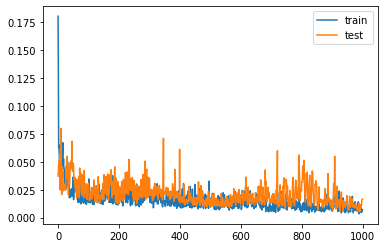

In [426]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('ecb.csv', header=0, index_col=0)
values = dataset.values
# # integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 30
n_features = 11
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print("Reframed shape:", reframed.shape)
reframed = reframed.iloc[: , :-(n_features-1)]
print("Reframed shape after truncaiton of unnecessary targets:", reframed.shape)
reframed.to_csv("reframed.csv")

print(reframed.head())


# split into train and test sets
values = reframed.values
n_train_hours = 365 * 18
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
print("train prioir sape", train.shape)
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print("train test split (trainX, len train X and trainY", train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train test reshape (trainX, trainY and testX, testY)",train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



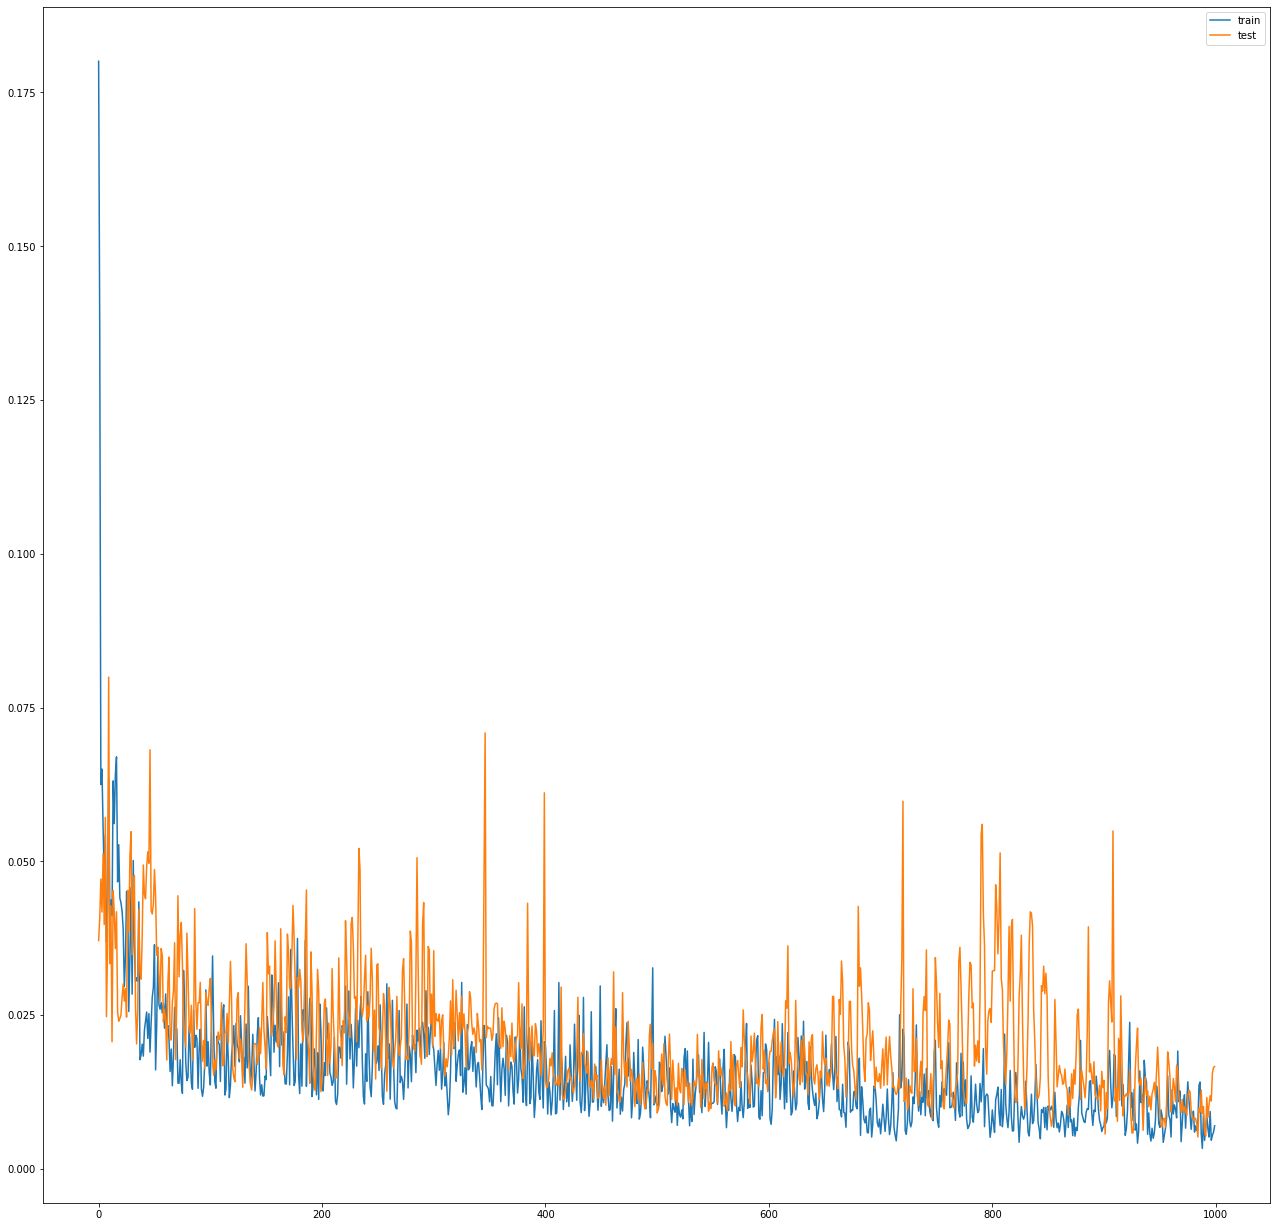

In [427]:
# plot history
plt.figure(figsize = (22,22))

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [417]:
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


In [428]:
# make a prediction
yhat = model.predict(test_X)


In [429]:
test_X.shape

(980, 30, 11)

In [430]:
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))


In [431]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -10:]), axis=1)

In [432]:
# invert scaling for forecast
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -10:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.168


In [433]:
1 - rmse

0.8320662956425383

In [424]:
inv_yhat[-10]

0.6007273

## Introduction to LSTM: Making Stock Movement Predictions Far into the Future

Long Short-Term Memory (LSTM) models are extremely powerful time-series models. A LSTM can predict an arbitrary number of steps into the future. A LSTM module (or a cell) has 5 essential components which allows them to model both long-term and short-term data. 
* Cell state ($c_t$) - This represents the internal memory of the cell which stores both short term memory and long-term memories
* Hidden state ($h_t$) - This is output state information calculated w.r.t. current input, previous hidden state and current cell input which you eventually use to predict the future stock market prices. Additionally, the hidden state can decide to only retrive the short or long-term or both types of memory stored in the cell state to make the next prediction.
* Input gate ($i_t$) - Decides how much information from current input flows to the cell state
* Forget gate ($f_t$) - Decides how much information from the current input and the previous cell state flows into the current cell state
5. Output gate ($o_t$) - Decides how much information from the current cell state flows into the hidden state, so that if needed LSTM can only pick the long-term memories or short-term memories and long-term memories

An LSTM cell looks like below.

<img src="lstm.png" alt="Drawing" style="width: 400px;"/>

And the equations for calculating each of these entities are as follows.

* $i_t = \sigma(W_{ix}x_t + W_{ih}h_{t-1}+b_i)$
* $\tilde{c}_t = \sigma(W_{cx}x_t + W_{ch}h_{t-1} + b_c)$
* $f_t = \sigma(W_{fx}x_t + W_{fh}h_{t-1}+b_f)$
* $c_t = f_t c_{t-1} + i_t \tilde{c}_t$
* $o_t = \sigma(W_{ox}x_t + W_{oh}h_{t-1}+b_o)$
* $h_t = o_t tanh(c_t)$

For a better (more technical) understanding about LSTMs you can refer http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Tensorflow provides a nice sub API (called RNN API) for implementing time series models. You will be using that for our implementations.


### Data Generator for LSTM

You are first going to implement a data generator to train our LSTM. This data generator will have a method called **unroll_batches(...)** which will output a set of *num_unrollings* batches of input data obtained sequentially, where a batch of data is of size *[batch_size, 1]*. Then each batch of input data will have a corresponding output batch of data. 

For example if *num_unrollings=3* and *batch_size=4* a set of unrolled batches it might look like,
* input data: $[x_0,x_10,x_20,x_30], [x_1,x_11,x_21,x_31], [x_2,x_12,x_22,x_32]$
* output data: $[x_1,x_11,x_21,x_31], [x_2,x_12,x_22,x_32], [x_3,x_13,x_23,x_33]$

#### Data Augmentation
Also to make our model robust you will not make the output for $x_t$ always $x_{t+1}$. Rather you will randomly sample an output from the set $x_{t+1},x_{t+2},\ldots,x_{t+N}$ where $N$ is a small window size. Here you are making the following assumption.

* $x_{t+1},x_{t+2},\ldots,x_{t+N}$ will not be very far from each other

I personally think is a reasonable assumption for stock movement prediction.

Below you illustrate how a batch of data is created visually.

<img src="batch.png" alt="Drawing" style="width: 600px;"/>